In [2]:
import numpy as np
import networkx as nx
from scipy.integrate import odeint
from scipy.special import expit #sigmoid function
import matplotlib.pyplot as plt 
import pandas as pd
from project4 import data

In [3]:
G=data(fname='project4.csv')

In [4]:
def network(G,inputs=()):
    """
    Analyze input networkX graph, G
    Use inputs to provide any other needed information.
    """
    nx.draw(G,node_size=1,edge_size=.1)
    plt.show()
    DG=nx.degree_histogram(G)
    plt.plot(DG)
    plt.xlabel('degree')
    plt.ylabel('number of countries')
    plt.show()
    Gnp=nx.to_numpy_matrix(G)
    if np.all(Gnp==Gnp.T):
        print('G is symmetric')
    else:
        print('G is not symmetric')
    Gmax=np.amax(Gnp)
    Nmax1,Nmax2=np.where(Gnp==Gmax)
    Nodes=np.array(G.node())
    print('The nodes for the maximul weight edge is %s %s' %(Nodes[Nmax1[0]],Nodes[Nmax1[1]]))
    Clist1,Clist2=np.where(Gnp>0.33*Gmax)
    string=('The countries with at least a third the weight of %s to %s are '%(Nodes[Nmax1[0]],Nodes[Nmax1[1]]))
    for C1,C2 in zip(Nodes[Clist1],Nodes[Clist2]):
        if (C2+' to '+C1) in string:
            pass
        else:
            string+=C1+' to '+C2+', '
    print(string)
    #Now we investigate the countries with less than 100 degree
    Gdegree=np.array(G.degree())[:,1].astype(int)
    Countries=np.where(Gdegree<100)
    string='The countries with less than 100 degrees are '
    for C in Nodes[Countries]:
        string+=C+' '
    print(string)
    total_weight=Gnp.sum(axis=0)
    Nodelist=np.array(G.nodes)
    v=np.zeros(196)
    v[:]=total_weight[0,:]
    print(v.shape)
    fig,ax=plt.subplots(figsize=(20,5))
    ax.bar(Nodelist,v)
    ax.set_yscale("log")
    plt.xticks(rotation=90,fontsize=5)
    plt.ylabel('total weight')
    plt.xlabel('country')
    plt.savefig('total_travel.eps', format='eps')
    def dfs(G,start='CHN'):
        ans={}
        Q=[]
        Q.append(start)
        while len(Q)>0:
            n=Q.pop()
            for v in G.adj[n]:
                if v not in ans.keys():
                    ans[v]=0
                    Q.append(v)
        if len(ans)==len(G):
            print('Every node is reachable from %s'%start)
        return ans
    ans=dfs(G)
    return None


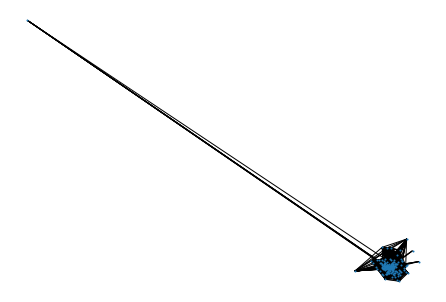

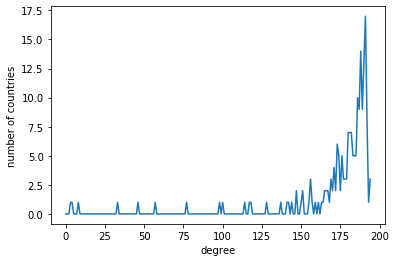

G is symmetric
The nodes for the maximul weight edge is CHN HKG
The countries with at least a third the weight of CHN to HKG are CAN to USA, CHN to HKG, CHN to MAC, MEX to USA, 
The countries with less than 100 degrees are AND BTN NIU NRU PSE SMR TLS TUV 
(196,)
Every node is reachable from CHN


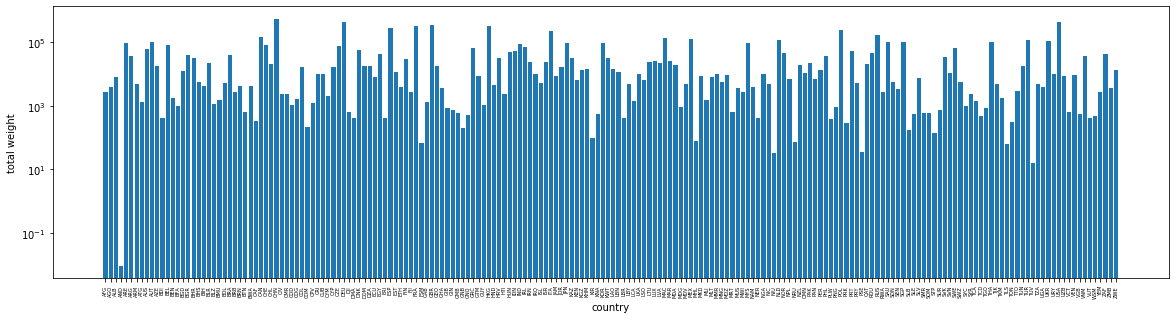

In [23]:
network(G)

In [21]:
def modelBH(G,x=0,i0=0.1,alpha=0.45,beta=0.3,gamma=1e-3,eps=1.0e-6,eta=8,tf=20,Nt=1000):
    """
    Simulate model Brockmann & Helbing SIR model

    Input:
    G: Weighted undirected Networkx graph
    x: node which is initially infected with j_x=j0
    j0: magnitude of initial condition
    alpha,beta,gamma,eps,eta: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    jarray: Nt+1 x N array containing j across the N network nodes at
                each time step.
    sarray: Nt+1 x N array containing s across network nodes at each time step
    """
    Fmn=nx.to_numpy_matrix(G)
    Flist=np.sum(Fmn,axis=1)
    Fn,AA=np.meshgrid(Flist,np.zeros_like(Flist))
    Pmn=Fmn/Fn
    Pmn=np.asarray(Pmn)
    N = G.number_of_nodes()
    tarray = np.linspace(0,tf,Nt+1)
    Parray=np.sum(Pmn,axis=0)
    A=Pmn-np.diag(Parray)
    y0=np.zeros(2*N)
    y0[x]=i0
    y0[N:]=1
    y0[x+N]=1-i0
    def sigma(Inp):
        sigma=np.divide(Inp**eta,(1+Inp**eta))
        return sigma
    def RHS(y,t):
        dy=np.zeros(2*N)
        j=y[:N]
        s=y[N:]
        dj=alpha*np.multiply(np.multiply(s,j),sigma(j/eps))-beta*j+gamma*np.dot(j,A)
        ds=-alpha*np.multiply(np.multiply(s,j),sigma(j/eps))+gamma*np.dot(s,A)
        dy[:N]=dj
        dy[N:]=ds
        return dy
    #constuct the initial condition
    ans=odeint(RHS,y0,tarray)
    jarray=ans[:,:N]
    sarray=ans[:,N:]
    return tarray,jarray,sarray


               

In [24]:
tarray,jarray,sarray=modelBH(G,x=0,i0=0.1,alpha=0.45,beta=0.3,gamma=1e-3,eps=1.0e-6,eta=8,tf=20,Nt=1000)

In [34]:
print(jarray[1000,:])

[3.89300741e-02 1.11303339e-08 4.42877372e-09 6.24778537e-11
 1.56160164e-04 7.96394110e-10 8.03492551e-08 3.45994398e-10
 5.40440428e-08 1.12993804e-08 1.63749365e-07 3.61758662e-08
 1.74427087e-08 1.62587338e-09 5.31494730e-09 1.67784493e-07
 6.58887268e-09 8.27683732e-08 4.15537532e-10 4.53697862e-08
 1.74355186e-09 1.43357257e-09 5.91444846e-10 7.92595211e-10
 2.81572343e-09 1.77689471e-09 4.43479157e-09 9.27017402e-08
 2.62970078e-09 2.28248932e-08 2.79633036e-08 1.32921835e-08
 7.47805023e-10 1.11159416e-08 2.92194075e-08 1.22237227e-08
 1.84339890e-08 1.28266491e-08 1.32763408e-08 9.98006219e-09
 3.49208457e-10 9.34551986e-10 5.90254608e-10 5.24871426e-10
 5.38348144e-09 3.62139660e-09 4.59016973e-08 1.30289415e-07
 3.23541452e-10 3.75735630e-08 7.18131710e-10 5.56196094e-09
 1.58766102e-09 5.19360619e-08 1.89843699e-07 3.68645292e-09
 9.29724894e-09 6.27760929e-08 1.98262282e-08 1.32655198e-08
 9.42993414e-09 9.37576255e-10 8.10299775e-09 5.61622739e-08
 1.67072022e-08 1.519134

In [26]:
Node=np.array(G.nodes())
print(np.where(Node=='CHN'))


(array([33]),)


In [28]:
def analyze(G):
    """Compute effective distance matrix and
    analyze simulation results
    Input:
        G: Weighted undirected NetworkX graphs
        inputs: can be used to provide additional needed information
    Output:
        D: N x N effective distance matrix (a numpy array)

    """
    #Start of calculating D
    Fmn=nx.to_numpy_matrix(G)
    Flist=np.sum(Fmn,axis=1)
    Fn,AA=np.meshgrid(Flist,np.zeros_like(Flist))
    Pmn=Fmn/Fn
    Pmn=np.asarray(Pmn)
    d=1-np.log(Pmn)
    D=np.zeros([196,196])
    Inf=float('inf')
    def dijkstra(d,start_node):
        Udict={}
        Udict[start_node]=0
        Edict={}
        while len(Udict)>0:
            dmin=Inf
            for k,v in Udict.items():
                if v<dmin:
                    dmin=v
                    n=k
            vec=d[:,n].copy()
            vec+=dmin
            for i in range(len(vec)):
                if i in Edict:
                    pass
                elif i in Udict:
                    Udict[i]=min(Udict[i],vec[i])
                else:
                    Udict[i]=vec[i]
            Edict[n]=Udict.pop(n)
            D[n,N]=Edict[n]
        return None
    for N in range(196):
        dijkstra(d,N)  
    #End of calculating D
    Dlist=[]
    Tlist=[]
    Fmn=nx.to_numpy_matrix(G)
    Flist=np.array(np.sum(Fmn,axis=1))
    tarray,jarray,sarray=modelBH(G,x=33,i0=1/Flist[33],alpha=.045,beta=.030,gamma=1e-3,eps=1.0e-6,eta=8,tf=1000,Nt=10000)
    dists=D[:,33]

    for i in range(196):
        deff=dists[i]
        ji=jarray[:,i]*Flist[i]
        if np.any(ji>1):
            Tn=np.where(ji>1)[0][0]
            Ta=tarray[Tn]
            Tlist.append(Ta)
            Dlist.append(deff)
    else:
        print('Node %i is not infected'%i)
    plt.scatter(Dlist,Tlist)
    m,c=np.polyfit(np.array(Dlist),np.array(Tlist),deg=1)
    R=np.corrcoef(np.array(Dlist),np.array(Tlist))[0,1]
    print(R**2)
    plt.plot(Dlist,m*np.array(Dlist)+c,label=('R**2=%.3f, gradient=%.2f'%(R**2,m)))
    plt.ylabel('T_a')
    plt.xlabel('D_eff')
    plt.legend()
    #plt.savefig('D_Ta.eps', format='eps')
    plt.show()
    dists=D[:,33]
    dd=dists.copy()

    countries=np.argsort(dd)[0:5]

    Dlist1=[]
    Dlist2=[]
    Dlist3=[]
    Dlist4=[]
    Dlist5=[]
    Tlist=[]
    Fmn=nx.to_numpy_matrix(G)
    Flist=np.array(np.sum(Fmn,axis=1))
    tarray,jarray,sarray=modelBH(G,x=33,i0=1/Flist[33],alpha=.45,beta=.30,gamma=1e-3,eps=1.0e-6,eta=8,tf=1000,Nt=10000)
    dists=D[:,33]

    for i in range(196):
        deff=dists[i]
        ji=jarray[:,i]*Flist[i]
        if np.any(ji>1):
            Tn=np.where(ji>1)[0][0]
            Ta=tarray[Tn]
            Tlist.append(Ta)
            Dlist1.append(D[i,countries[0]])
            Dlist2.append(D[i,countries[1]])
            Dlist3.append(D[i,countries[2]])
            Dlist4.append(D[i,countries[3]])
            Dlist5.append(D[i,countries[4]])
        else:
            print('Node %i not infected'%m)
    R1=np.corrcoef(np.array(Dlist1),np.array(Tlist))[0,1]**2
    R2=np.corrcoef(np.array(Dlist2),np.array(Tlist))[0,1]**2
    R3=np.corrcoef(np.array(Dlist3),np.array(Tlist))[0,1]**2
    R4=np.corrcoef(np.array(Dlist4),np.array(Tlist))[0,1]**2
    R5=np.corrcoef(np.array(Dlist5),np.array(Tlist))[0,1]**2
    plt.scatter(Dlist1,Tlist,s=.3,label=('Country 1, R^2=%.5f'%R1))
    plt.scatter(Dlist2,Tlist,s=.3,label=('Country 2, R^2=%.5f'%R2))
    plt.scatter(Dlist3,Tlist,s=.3,label=('Country 3, R^2=%.5f'%R3))
    plt.scatter(Dlist4,Tlist,s=.3,label=('Country 4, R^2=%.5f'%R4))
    plt.scatter(Dlist5,Tlist,s=.3,label=('Country 5, R^2=%.5f'%R5))
    plt.legend()
    plt.xlabel('deff')
    plt.ylabel('T_a')
    #plt.savefig('predict.eps', format='eps')
    plt.show()
    print('R value for country 1,2,3,4,5 are %.3f %.3f %.3f %.3f %.3f'%(R1,R2,R3,R4,R5))
    
    dists=D[:,33]
    Rlist=[]
    Fmn=nx.to_numpy_matrix(G)
    Flist=np.array(np.sum(Fmn,axis=1))
    for b in np.arange(.05,.5,.05):
        a=1.5*b
        Tlist=[]
        Dlist=[]
        tarray,jarray,sarray=modelBH(G,x=33,i0=1/Flist[33],alpha=a,beta=b,gamma=1e-3,eps=1.0e-6,eta=8,tf=1000,Nt=10000)
        for m in range(196):
            deff=dists[m]
            ji=jarray[:,m]*Flist[m]
            if np.any(ji>1):
                Tn=np.where(ji>1)[0][0]
                Ta=tarray[Tn]
                Tlist.append(Ta)
                Dlist.append(deff)
            else:
                print('Node %i not infected'%m)
        R=np.corrcoef(np.array(Dlist),np.array(Tlist))[0,1]
        print(R)
        Rlist.append(R**2)
    plt.plot(np.arange(.05,.5,.05),Rlist)
    plt.xlabel('beta')
    plt.ylabel('R^2')
    #plt.show()
    plt.savefig('b_R.eps', format='eps')
    return D

/home/hanwen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Node 195 is infected
0.9747931970371521


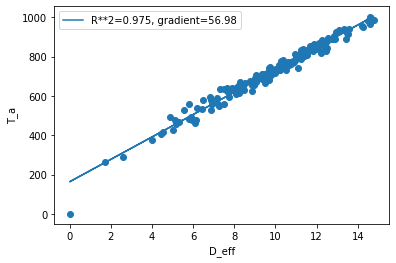

Node 56 not infected


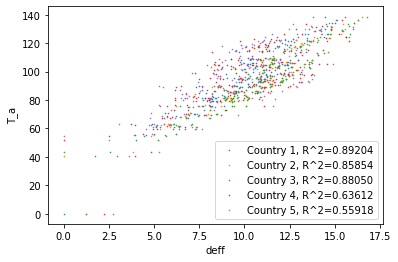

R value for country 1,2,3,4,5 are 0.892 0.859 0.880 0.636 0.559
Node 3 not infected
0.9860400285432542
Node 3 not infected
0.9800072757537885
Node 3 not infected
0.9733151311502195
Node 3 not infected
0.9654294369091836
Node 3 not infected
0.95568065615758
Node 3 not infected
0.9444782315321835
Node 3 not infected
0.9346362158745738
Node 3 not infected
0.9244397021980066
Node 3 not infected
0.9147358254305318
[[ 0.         10.1162782  11.82079194 ... 10.4213882  11.03205797
  11.59480987]
 [ 9.72360318  0.         12.39549305 ...  5.8272774   7.09974422
   7.27901302]
 [10.72044772 11.68782386  0.         ... 11.41046633 12.36730619
  12.99514049]
 ...
 [ 7.65580879  3.45437301  9.74523113 ...  0.          2.54582003
   1.58467416]
 [10.71786978  7.17823105 13.15346221 ...  4.99721125  0.
   3.33980619]
 [ 9.97960567  6.05648384 12.4802805  ...  2.73504938  2.03879018
   0.        ]]


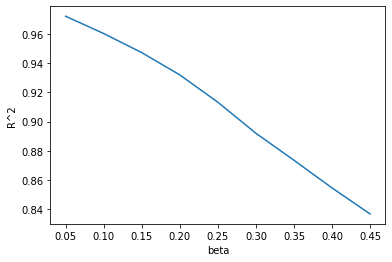

In [29]:
D=analyze(G)
print(D)

Node 3 not infected
[0.00936073]
0.9860400285432542
Node 3 not infected
[0.00936073]
0.9800072757537885
Node 3 not infected
[0.00936073]
0.9733151311502195
Node 3 not infected
[0.00936073]
0.9654294369091836
Node 3 not infected
[0.00936073]
0.95568065615758
Node 3 not infected
[0.00936073]
0.9444782315321835
Node 3 not infected
[0.00936073]
0.9346362158745738
Node 3 not infected
[0.00936073]
0.9244397021980066
Node 3 not infected
[0.00936073]
0.9147358254305318


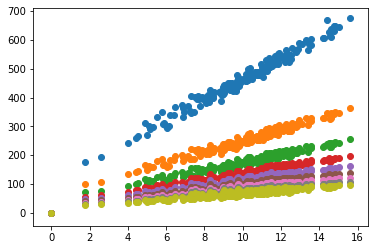

We have varied $\beta$ and defind $\alpha$ as $ 1.5\times\beta$ in this case, suppose the 'exponential' growth term increase, the model become less accurate, whereas if the $\alpha$ and $\beta$ term are smaller, the 'diffusion term will dominate, which involves using the $P_{mn}$ matrix, then in this case the model developed in the paper fits more and more accurately to the result. 

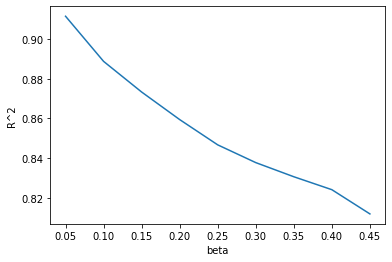

In [48]:
print(D)

[[ 0.         10.1162782  11.82079194 ... 10.4213882  11.03205797
  11.59480987]
 [ 9.72360318  0.         12.39549305 ...  5.8272774   7.09974422
   7.27901302]
 [10.72044772 11.68782386  0.         ... 11.41046633 12.36730619
  12.99514049]
 ...
 [ 7.65580879  3.45437301  9.74523113 ...  0.          2.54582003
   1.58467416]
 [10.71786978  7.17823105 13.15346221 ...  4.99721125  0.
   3.33980619]
 [ 9.97960567  6.05648384 12.4802805  ...  2.73504938  2.03879018
   0.        ]]


In [49]:
print(D.T)

[[ 0.          9.72360318 10.72044772 ...  7.65580879 10.71786978
   9.97960567]
 [10.1162782   0.         11.68782386 ...  3.45437301  7.17823105
   6.05648384]
 [11.82079194 12.39549305  0.         ...  9.74523113 13.15346221
  12.4802805 ]
 ...
 [10.4213882   5.8272774  11.41046633 ...  0.          4.99721125
   2.73504938]
 [11.03205797  7.09974422 12.36730619 ...  2.54582003  0.
   2.03879018]
 [11.59480987  7.27901302 12.99514049 ...  1.58467416  3.33980619
   0.        ]]


In [32]:
A=[[1,2,3],[4,5,6],[7,8,9]]
B=[1,2,3]
print(np.dot(A,B))
print(np.dot(B,A))

[14 32 50]
[30 36 42]
